In [71]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt

In [72]:
class Player:
    def __init__(self, eps, valuation):
        self.eps = eps
        self.valuation = valuation
        self.alg = np.zeros(1)
        self.choice = 0
        self.regret = np.zeros(0)
        self.choice_vector = np.zeros(0)
    
    def geo_discretize(self, k):
        self.a = np.array([np.round(self.valuation - (1+(self.valuation**(1/(k)) - 1))**i, 2) for i in range(1,k+1)])
        self.V = np.zeros(k)
        self.prob = 1/k*np.ones(k)

    
    def update_prob(self):
        if self.eps == np.Inf:
            self.prob = np.zeros(self.V.shape)
            self.prob[np.argmax(self.V)] = 1
        else:
            self.prob = (1+self.eps)**(self.V.astype(np.float128)/self.valuation) / np.sum((1+self.eps)**(self.V.astype(np.float128)/self.valuation))

    
    def pick_action(self):
        self.choice = rand.choices(self.a, weights=self.prob)[0]
        self.choice_vector = np.append(self.choice_vector, self.choice)
        return self.choice
    

    def update_payoffs(self, opposing_bid, round):
        for i, a in enumerate(self.a):
            if a > opposing_bid:
                self.V[i] += self.valuation - a
            elif a == opposing_bid:
                self.V[i] +=  .5*(self.valuation - a)
        if self.choice > opposing_bid:
            self.alg = np.append(self.alg, self.alg[-1] + self.valuation - self.choice)
        elif self.choice == opposing_bid:
            self.alg = np.append(self.alg, self.alg[-1] + .5*(self.valuation - self.choice))
        else:
            self.alg = np.append(self.alg, self.alg[-1])
        self.regret = np.append(self.regret, (np.max(self.V) - self.alg[-1])/ round)

In [73]:
def monte_carlo(n, trials, eps):
    p1_regret = np.zeros((trials, eps.shape[0]))
    p2_regret = np.zeros((trials, eps.shape[0]))
    p1_choice_vector = np.zeros((trials, eps.shape[0], n))
    p2_choice_vector = np.zeros((trials, eps.shape[0], n))
    for N in range(trials):
        for x,e in enumerate(eps):
            player1 = Player(e, v1)
            player1.geo_discretize(k)
            player2 = Player(e, v2)
            player2.geo_discretize(k)
            for i in range(1, n+1):
                player1.update_prob()
                player2.update_prob()
                p1_action = player1.pick_action()
                p2_action = player2.pick_action()
                player1.update_payoffs(p2_action, i)
                player2.update_payoffs(p1_action, i)
            p1_regret[N,x] = player1.regret[-1]
            p2_regret[N,x] = player2.regret[-1]
            p1_choice_vector[N,x, :] = player1.choice_vector
            p2_choice_vector[N,x, :] = player2.choice_vector
        
    p1_regret = np.average(p1_regret, 0)
    p2_regret = np.average(p2_regret, 0)
    p1_choice_vector = np.average(p1_choice_vector, 0)
    p2_choice_vector = np.average(p2_choice_vector, 0)
    return p1_regret, p2_regret,p1_choice_vector, p2_choice_vector


In [74]:
n = 250
v1 = 80
v2 = 60
k =20

In [75]:
eps = np.arange(0,2.1,.1)
eps = np.append(eps, np.Inf)

In [76]:
def plot_R_vs_lr(eps, reg, title= ""):
    plt.plot(eps, reg)
    plt.plot([0, np.max(eps[:-1])], [reg[-1], reg[-1]], "--", label = 'FTL Regret')
    plt.plot([0, np.max(eps[:-1])], [reg[0], reg[0]], "--", label = 'Random Guessing Regret')
    plt.legend(fontsize = 'x-small')
    plt.ylabel("Regret")
    plt.xlabel("Learning Rate")
    plt.title(title)

In [101]:
p1_regret,p2_regret,p1_choice_vector,p2_choice_vector = monte_carlo(200, 200, eps)

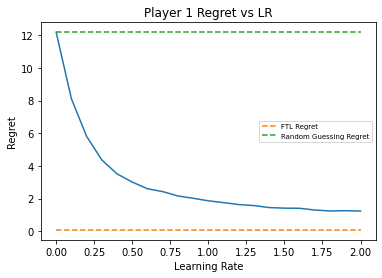

In [78]:
plot_R_vs_lr(eps, p1_regret, "Player 1 Regret vs LR")

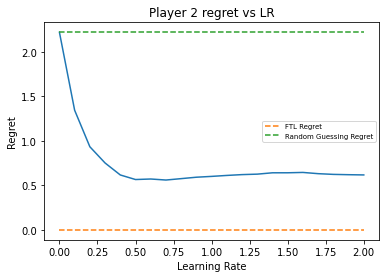

In [79]:
plot_R_vs_lr(eps, p2_regret, "Player 2 regret vs LR")

Text(0, 0.5, 'Bid Amount')

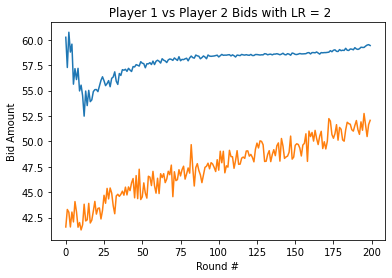

In [80]:
plt.plot(p1_choice_vector[20], label = "Player 1 bid")
plt.plot(p2_choice_vector[20], label = "Player 2 bid")
plt.title(" Player 1 vs Player 2 Bids with LR = 2")
plt.xlabel("Round #")
plt.ylabel("Bid Amount")

Text(0, 0.5, 'Bid Amount')

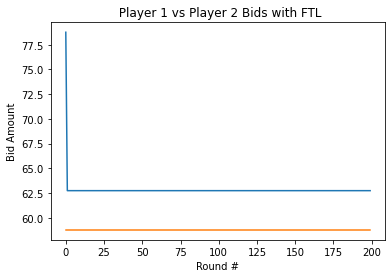

In [81]:
plt.plot(p1_choice_vector[-1], label = "Player 1 bid")
plt.plot(p2_choice_vector[-1], label = "Player 2 bid")
plt.title(" Player 1 vs Player 2 Bids with FTL")
plt.xlabel("Round #")
plt.ylabel("Bid Amount")

In [82]:
def monte_carlo_p2_fixed(n, trials, eps, eps2):
    p1_regret = np.zeros((trials, eps.shape[0]))
    p2_regret = np.zeros((trials, eps.shape[0]))
    p1_choice_vector = np.zeros((trials, eps.shape[0], n))
    p2_choice_vector = np.zeros((trials, eps.shape[0], n))
    for N in range(trials):
        for x,e in enumerate(eps):
            player1 = Player(e, v1)
            player1.geo_discretize(k)
            player2 = Player(eps2, v2)
            player2.geo_discretize(k)
            for i in range(1, n+1):
                player1.update_prob()
                player2.update_prob()
                p1_action = player1.pick_action()
                p2_action = player2.pick_action()
                player1.update_payoffs(p2_action, i)
                player2.update_payoffs(p1_action, i)
            p1_regret[N,x] = player1.regret[-1]
            p2_regret[N,x] = player2.regret[-1]
            p1_choice_vector[N,x, :] = player1.choice_vector
            p2_choice_vector[N,x, :] = player2.choice_vector
        
    p1_regret = np.average(p1_regret, 0)
    p2_regret = np.average(p2_regret, 0)
    p1_choice_vector = np.average(p1_choice_vector, 0)
    p2_choice_vector = np.average(p2_choice_vector, 0)
    return p1_regret, p2_regret,p1_choice_vector, p2_choice_vector

In [83]:
p1_regret,_,p1_choice_vector,_ = monte_carlo_p2_fixed(200, 20, eps, 0)

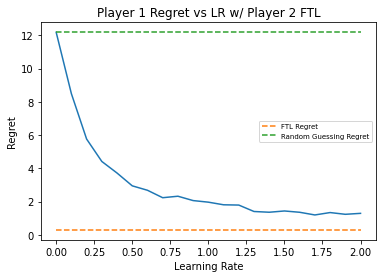

In [84]:
plot_R_vs_lr(eps, p1_regret, "Player 1 Regret vs LR w/ Player 2 FTL")

In [85]:
def monte_carlo_p1_fixed(n, trials, eps, eps1):
    p1_regret = np.zeros((trials, eps.shape[0]))
    p2_regret = np.zeros((trials, eps.shape[0]))
    p1_choice_vector = np.zeros((trials, eps.shape[0], n))
    p2_choice_vector = np.zeros((trials, eps.shape[0], n))
    for N in range(trials):
        for x,e in enumerate(eps):
            player1 = Player(eps1, v1)
            player1.geo_discretize(k)
            player2 = Player(e, v2)
            player2.geo_discretize(k)
            for i in range(1, n+1):
                player1.update_prob()
                player2.update_prob()
                p1_action = player1.pick_action()
                p2_action = player2.pick_action()
                player1.update_payoffs(p2_action, i)
                player2.update_payoffs(p1_action, i)
            p1_regret[N,x] = player1.regret[-1]
            p2_regret[N,x] = player2.regret[-1]
            p1_choice_vector[N,x, :] = player1.choice_vector
            p2_choice_vector[N,x, :] = player2.choice_vector
        
    p1_regret = np.average(p1_regret, 0)
    p2_regret = np.average(p2_regret, 0)
    p1_choice_vector = np.average(p1_choice_vector, 0)
    p2_choice_vector = np.average(p2_choice_vector, 0)
    return p1_regret, p2_regret,p1_choice_vector, p2_choice_vector

In [86]:
p2_regret,_,p2_choice_vector,_ = monte_carlo_p1_fixed(200, 20, eps, .1)

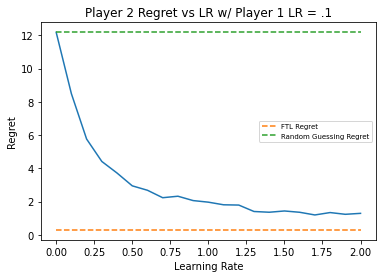

In [87]:
plot_R_vs_lr(eps, p1_regret, "Player 2 Regret vs LR w/ Player 1 LR = .1")

In [106]:
n = 250
v1 = 50
v2 = 50
k =20

In [108]:
p1_regret,p2_regret,p1_choice_vector,p2_choice_vector = monte_carlo(200, 200, eps)

Text(0, 0.5, 'Bid Amount')

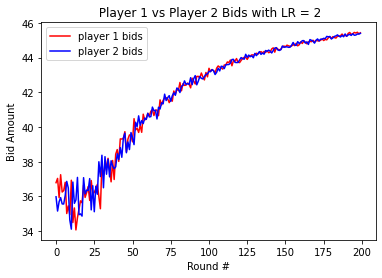

In [90]:
plt.plot(p1_choice_vector[20], 'r', label = "player 1 bids")
plt.plot(p2_choice_vector[20], "b", label = "player 2 bids")
plt.title(" Player 1 vs Player 2 Bids with LR = 2")
plt.xlabel("Round #")
plt.legend()
plt.ylabel("Bid Amount")

Text(0, 0.5, 'Bid Amount')

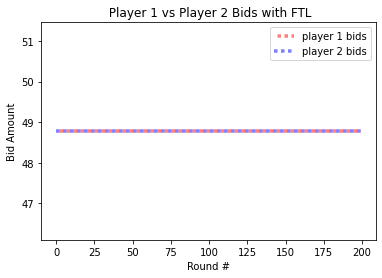

In [124]:
plt.plot(p1_choice_vector[-1], 'r',ls = (5, (1,1)), alpha = .5, linewidth=3.5, label = "player 1 bids")
plt.plot(p2_choice_vector[-1], "b", ls = (0, (1,1)), alpha = .5, linewidth=3.5, label = "player 2 bids")
plt.legend()
plt.title(" Player 1 vs Player 2 Bids with FTL")
plt.xlabel("Round #")
plt.ylabel("Bid Amount")

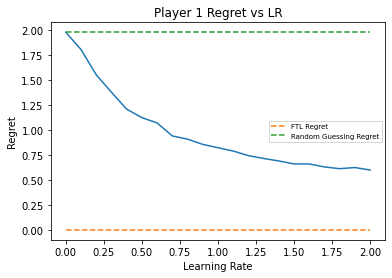

In [92]:
plot_R_vs_lr(eps, p1_regret, "Player 1 Regret vs LR")

In [93]:
p1_regret,p2_regret,p1_choice_vector,p2_choice_vector = monte_carlo_p2_fixed(200, 200, eps, 2)

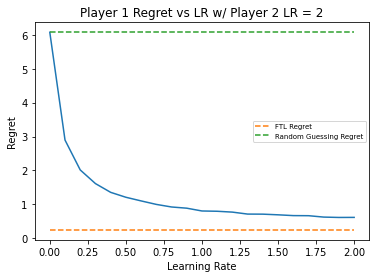

In [94]:
plot_R_vs_lr(eps, p1_regret, "Player 1 Regret vs LR w/ Player 2 LR = 2")

Text(0, 0.5, 'Bid Amount')

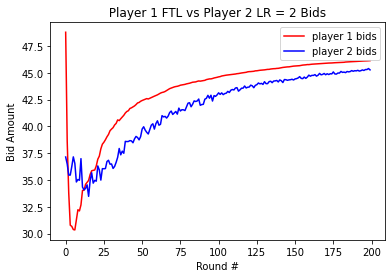

In [95]:
plt.plot(p1_choice_vector[-1], 'r', label = "player 1 bids")
plt.plot(p2_choice_vector[20], "b", label = "player 2 bids")
plt.title(" Player 1 FTL vs Player 2 LR = 2 Bids ")
plt.xlabel("Round #")
plt.legend()
plt.ylabel("Bid Amount")

In [96]:
## Part 2
class ExploitativePlayer:
    def __init__(self, lower, upper, valuation, interval):
        self.valuation = valuation
        self.lower = lower
        self.upper = upper
        self.choice = lower
        self.regret = np.zeros(0)
        self.interval = interval
        self.alg = np.zeros(1)
        self.counter = 0
        self.choice_vector= np.zeros(0)
    
    def pick_action(self):
        self.counter +=1
        if self.counter == self.interval: 
            self.counter = 0
            self.choice = self.upper
            self.choice_vector = np.append(self.choice_vector, self.choice)
            return self.upper
        self.choice = self.lower
        self.choice_vector = np.append(self.choice_vector, self.choice)
        return self.lower


    def update_payoffs(self, opposing_bid, round):
        if self.choice > opposing_bid:
            self.alg = np.append(self.alg, self.alg[-1] + self.valuation - self.choice)
        else:
            self.alg = np.append(self.alg, self.alg[-1])


In [97]:
n = 250
v1 = 80
v2 = 60
k = 20

player1 = Player(np.Inf, v1)
player1.geo_discretize(k)
player2 = ExploitativePlayer(0,15.75,v2,6)

for i in range(1, n+1):
    player1.update_prob()
    p1_action = player1.pick_action()
    p2_action = player2.pick_action()
    player1.update_payoffs(p2_action, i)
    player2.update_payoffs(p1_action, i)

Text(0.5, 1.0, 'Player 1 vs Player 2 Bids')

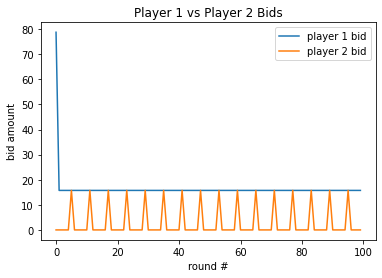

In [98]:
plt.plot(player1.choice_vector[0:100], label = "player 1 bid")
plt.plot(player2.choice_vector[0:100], label = "player 2 bid")
plt.xlabel("round #")
plt.ylabel("bid amount")
plt.legend()
plt.title("Player 1 vs Player 2 Bids")

Text(0.5, 1.0, 'Player Payoffs')

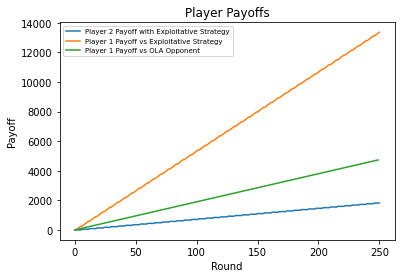

In [99]:
plt.plot(player2.alg, label = "Player 2 Payoff with Exploitative Strategy")
plt.plot(player1.alg, label = "Player 1 Payoff vs Exploitative Strategy")
plt.plot([19 * i for i in range(250)], label = "Player 1 Payoff vs OLA Opponent")
plt.legend(fontsize = 'x-small')
plt.ylabel("Payoff")
plt.xlabel("Round")
plt.title("Player Payoffs")